# General setting

In all of the following graphs we use the transition probabilites estimated from group 4 of John Rust's 1987 paper. We stylize the cost parameters to (50, 400), instead if (10, 2.27). The simulation exercises are always with 200 buses over 70000 periods. For the construction of the uncertainty sets we always use the mean number of observations 4292 / 78.

In [1]:
extract_zips()

# Transition probabilities

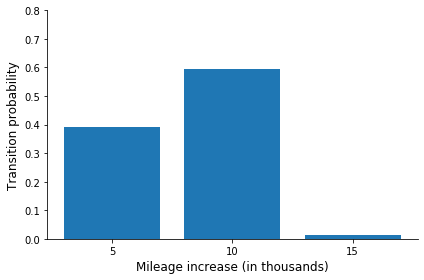

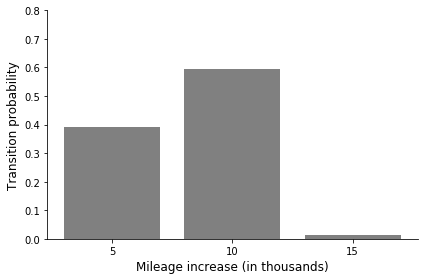

In [58]:
state = 12
get_probabilities(state)

upper bound [0.53631945 0.70635137 0.12207669]
lower bound [0.2722283  0.43765839 0.00119019]


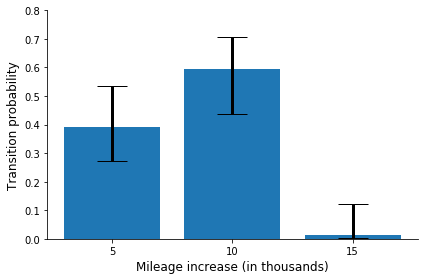

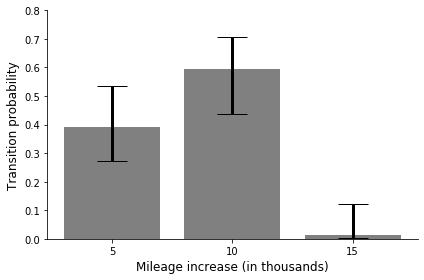

In [59]:
get_probabilities_bar(state)

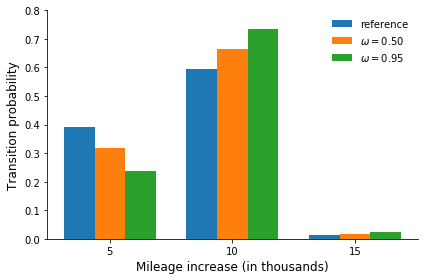

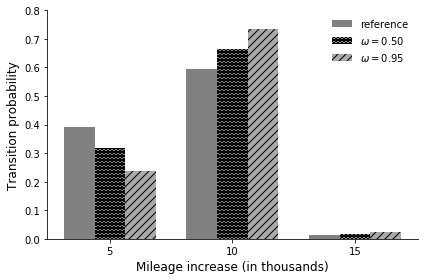

In [60]:
get_probability_shift(state)

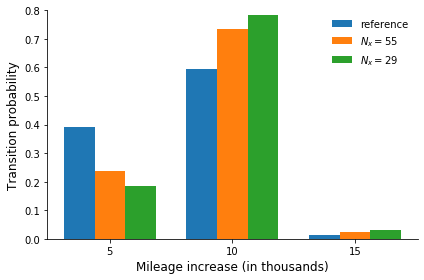

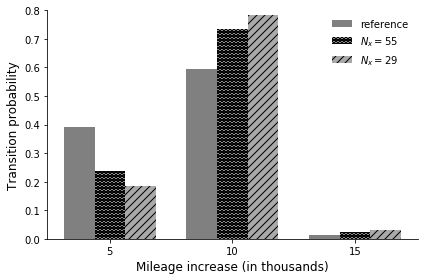

In [61]:
get_probability_shift_data(state)

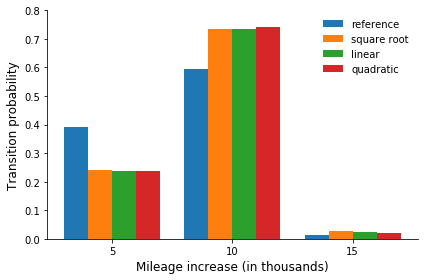

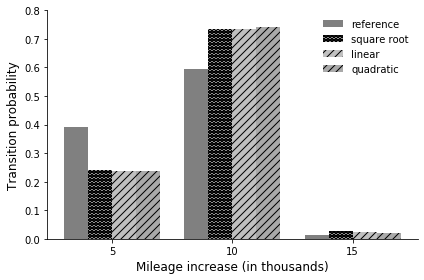

In [62]:
get_probability_shift_models(state, 0.95)

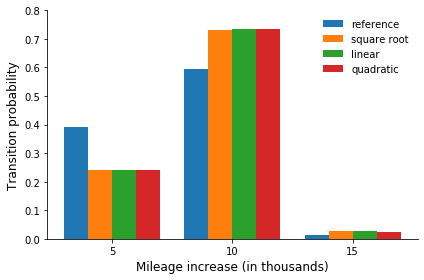

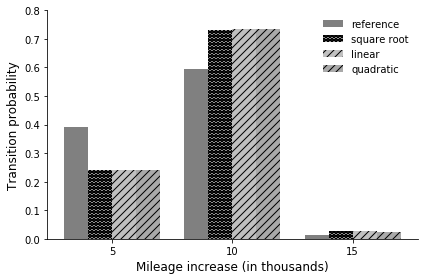

In [63]:
get_probability_shift_models(10, 0.95)

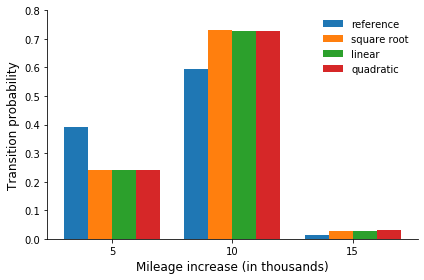

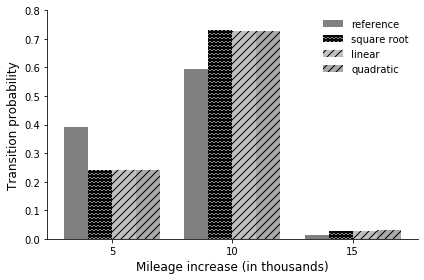

In [123]:
get_probability_shift_models(5, 0.95)

In [9]:
df_probability_shift(10)

,0,4292_0.50_lin,4292_0.95_lin,4292_0.95_quad,4292_0.95_sqrt,2223_0.95_lin
0,0.391892,0.316573,0.239904,0.239389,0.240500,0.187013
1,0.595294,0.665717,0.734251,0.735525,0.732836,0.777895
2,0.012815,0.017709,0.025845,0.025086,0.026664,0.035092


In [10]:
df_probability_shift(20)

,0,4292_0.50_lin,4292_0.95_lin,4292_0.95_quad,4292_0.95_sqrt,2223_0.95_lin
0,0.391892,0.316588,0.239406,0.236672,0.241154,0.185432
1,0.595294,0.665677,0.735482,0.744204,0.731347,0.781748
2,0.012815,0.017735,0.025112,0.019124,0.027500,0.032820


In [11]:
df_probability_shift(30)

,0,4292_0.50_lin,4292_0.95_lin,4292_0.95_quad,4292_0.95_sqrt,2223_0.95_lin
0,0.391892,0.316660,0.239439,0.000000,0.241838,0.185534
1,0.595294,0.665589,0.735375,0.978927,0.729836,0.781500
2,0.012815,0.017751,0.025186,0.021073,0.028326,0.032966


# Policy Features
 

In [121]:
min_states = {
    "linear": 0,
    "sqrt": 0,
    "quad": 0,
}
max_states = {
    "linear": 50,
    "sqrt": 50,
    "quad": 50,
}
state_steps = {
    "linear": 10,
    "sqrt": 10,
    "quad": 10,
}
df = df_maintenance_probabilties_lin(min_states["linear"], max_states["linear"])
df[df["mileage_thousands"] == 150]

,mileage_thousands,0_lin,0.5_lin,0.95_lin,0_sqrt,0.5_sqrt,0.95_sqrt,0_quad,0.5_quad,0.95_quad
30,150,0.000459,0.000628,0.000857,0.049025,0.061039,0.07544,2.292345e-12,3.433675e-12,5.173892e-12


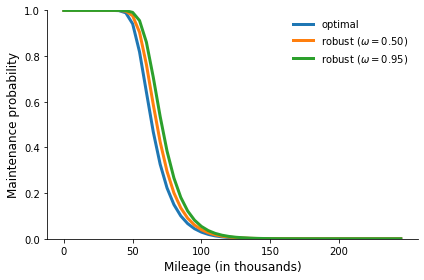

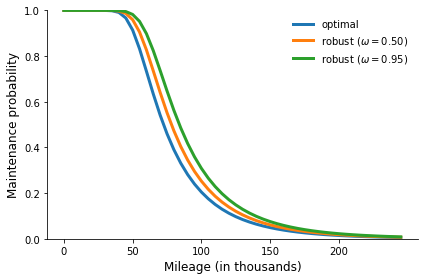

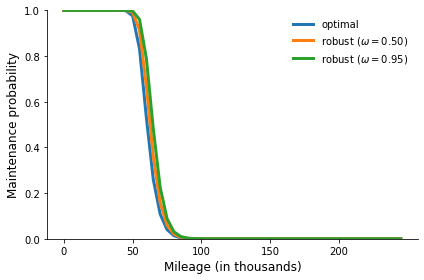

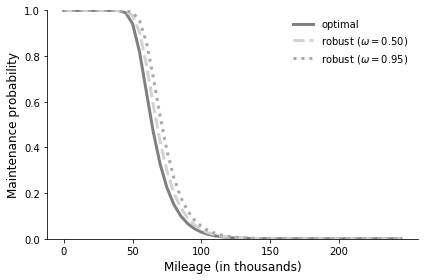

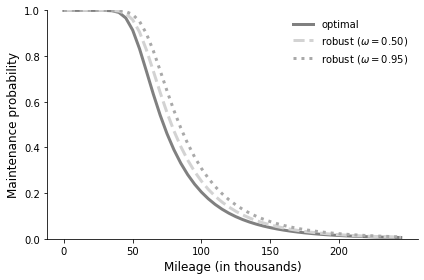

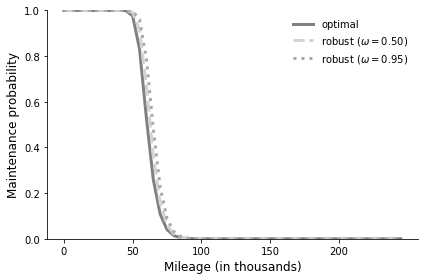

In [122]:
get_maintenance_probabilities(min_states, max_states, state_steps)

# Policy performance

In [99]:
max_period = 120

init_dict = {
    "disc_fac": 0.9999,
    "buses": 1,
    "periods": 50,
    "seed": 16,
}
df = get_demonstration_df(init_dict, max_period)

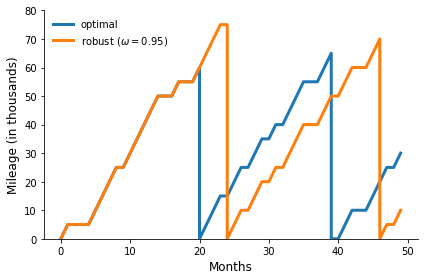

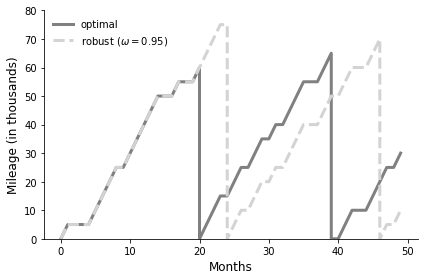

In [100]:
max_mileage = 80
get_demonstration(df, max_period, max_mileage)

In [18]:
df_thresholds("linear")

,omega,threshold
0,0.00,12
1,0.01,12
2,0.02,12
3,0.03,12
4,0.04,12
...,...,...
95,0.95,13
96,0.96,13
97,0.97,13
98,0.98,13


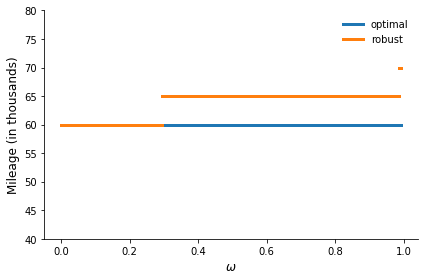

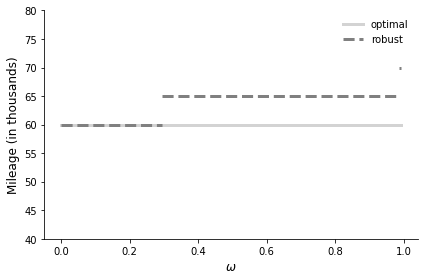

In [102]:
y_0 = 40
y_1 = 80
get_replacement_thresholds("linear", y_0, y_1)

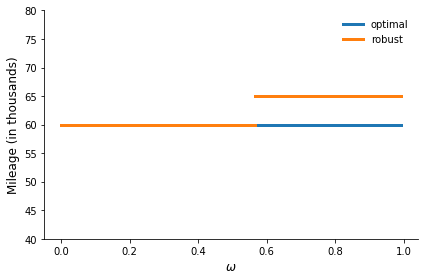

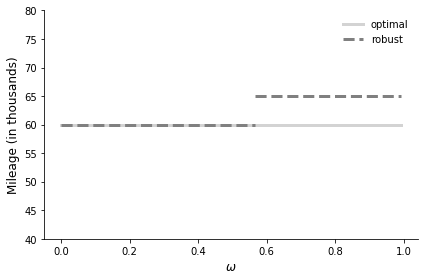

In [103]:
get_replacement_thresholds("quad", y_0, y_1)

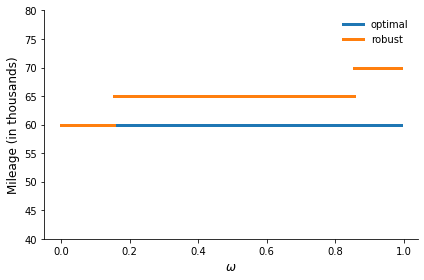

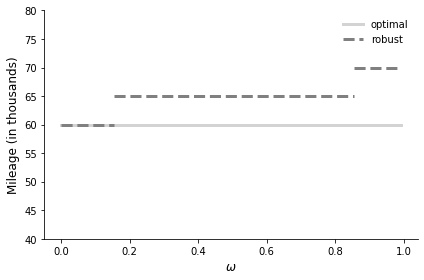

In [104]:
get_replacement_thresholds("sqrt", y_0, y_1)

In [22]:
df_lin = get_decision_rule_df("linear")
df_sqrt = get_decision_rule_df("sqrt")
df_quad = get_decision_rule_df("quad")

In [23]:
df_quad[df_quad["disc_strategy"] < df_quad["exp_value"]]

,months,disc_strategy,exp_value
19,19000,-46774.324200,-46627.104014
20,20000,-47557.857760,-46627.104014
21,21000,-48267.408513,-46627.104014
22,22000,-48908.784533,-46627.104014
23,23000,-49488.946800,-46627.104014
...,...,...,...
96,96000,-55002.609603,-46627.104014
97,97000,-55002.964352,-46627.104014
98,98000,-55003.285208,-46627.104014
99,99000,-55003.575244,-46627.104014


In [24]:
df_sqrt[df_sqrt["disc_strategy"] < df_sqrt["exp_value"]]

,months,disc_strategy,exp_value
25,25000,-48957.911840,-48724.969226
26,26000,-49374.845048,-48724.969226
27,27000,-49752.189593,-48724.969226
28,28000,-50093.643604,-48724.969226
29,29000,-50402.396844,-48724.969226
...,...,...,...
96,96000,-53334.897485,-48724.969226
97,97000,-53335.241480,-48724.969226
98,98000,-53335.552529,-48724.969226
99,99000,-53335.834045,-48724.969226


In [25]:
df_lin[df_lin["disc_strategy"] < df_lin["exp_value"]]

,months,disc_strategy,exp_value
22,22000,-48387.009848,-47886.501622
23,23000,-48961.108558,-47886.501622
24,24000,-49480.423195,-47886.501622
25,25000,-49950.375201,-47886.501622
26,26000,-50375.858176,-47886.501622
...,...,...,...
96,96000,-54416.407599,-47886.501622
97,97000,-54416.758216,-47886.501622
98,98000,-54417.075580,-47886.501622
99,99000,-54417.362814,-47886.501622


The underlying transition matrix is the worst case given omega=0.95
1.1363875191542625 1.0050807244471331 -47886.5016220565


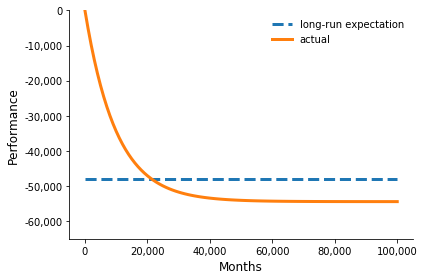

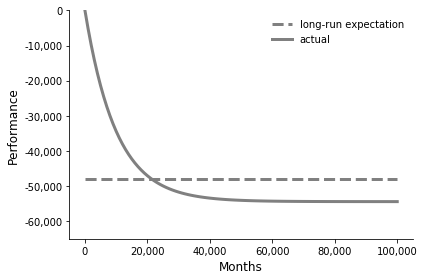

In [105]:
get_performance_decision_rules("linear")

The underlying transition matrix is the worst case given omega=0.95
1.0946356543685425 1.0049418901970346 -48724.96922608902


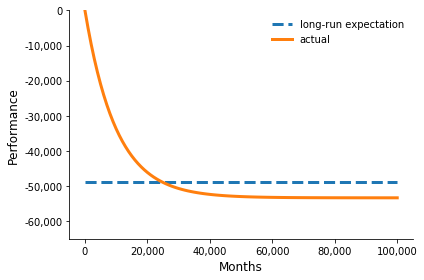

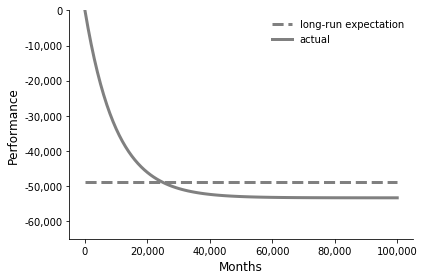

In [106]:
get_performance_decision_rules("sqrt")

The underlying transition matrix is the worst case given omega=0.95
1.1796537485268013 1.0042980244752688 -46627.104014305834


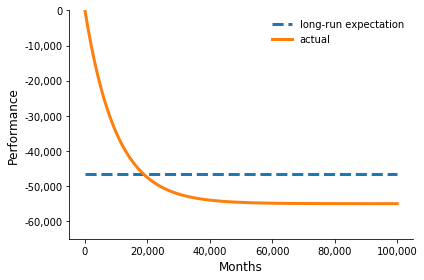

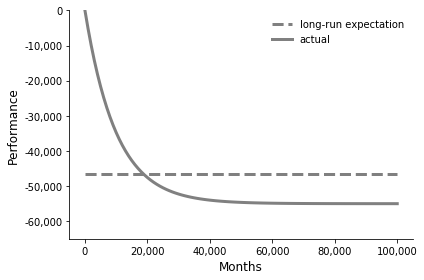

In [107]:
get_performance_decision_rules("quad")

In [29]:
df_lin = get_difference_df("linear")
df_sqrt = get_difference_df("quad")
df_quad = get_difference_df("sqrt")

The dataframe contains the difference for robust - nominal strategy.
The dataframe contains the difference for robust - nominal strategy.
The dataframe contains the difference for robust - nominal strategy.


In [30]:
df_lin

,omega,robust_95,robust_50,robust_05
0,0.00,-253.483056,-67.337663,-2.523948
1,0.01,-220.693274,-48.765979,396.213990
2,0.02,-207.150915,-39.546333,573.194349
3,0.03,-197.889123,-42.473062,676.433936
4,0.04,-190.156689,-32.438942,798.446472
...,...,...,...,...
95,0.95,279.982300,211.516061,6542.000937
96,0.96,301.790012,227.561641,6772.866351
97,0.97,318.201745,236.724433,7052.815538
98,0.98,359.732650,254.083764,7431.504934


In [39]:
# df_quad

In [40]:
# df_sqrt

In [41]:
# df_quad

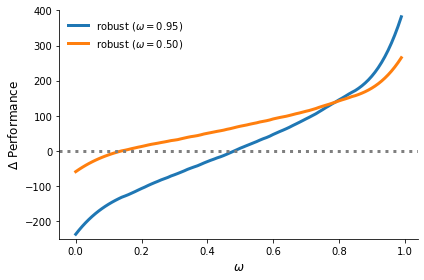

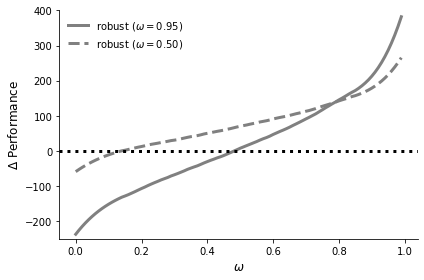

In [108]:
get_difference_plot("linear")

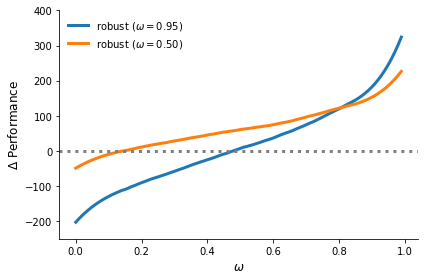

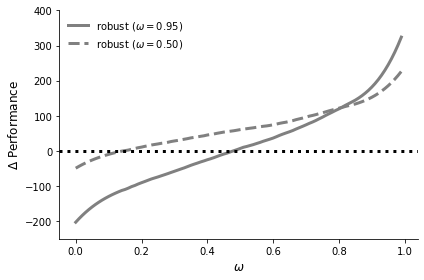

In [109]:
get_difference_plot("quad")

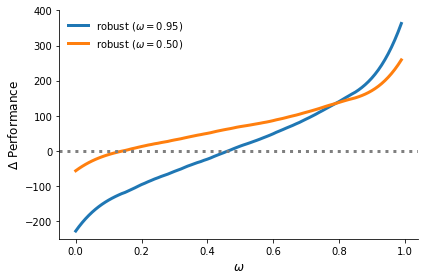

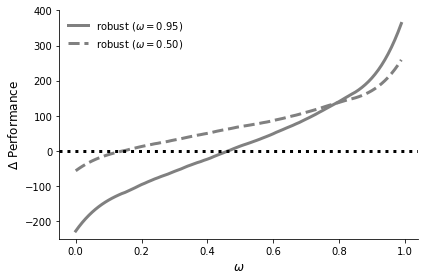

In [110]:
get_difference_plot("sqrt")

# Out of sample performance

0.0894
0.0966
0.1106


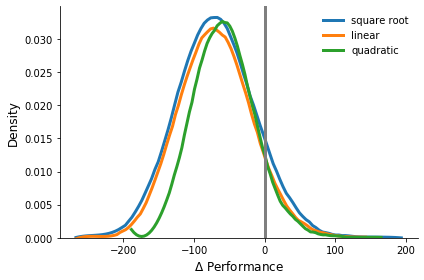

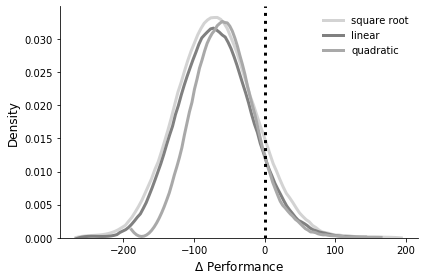

In [45]:
get_out_of_sample_diff(0.5, 100, 29)

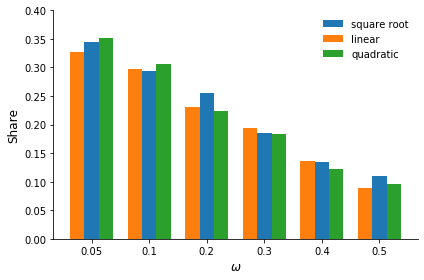

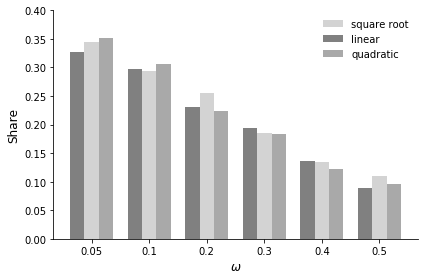

In [46]:
keys = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
width = 0.25
get_robust_performance(keys, width)